## Two Sigma: Rental Listing Inquiries
##### Group member: Ying Zhang, Zhian Wang, Zezhi Zhou

### Data cleaning:
Bining: bathrooms;num_photos

Winsorizing: price

Encoding: display_address; street_address; manager_id; building_id

Naive Bayes: probability(interest_level|manager_id)

Feature Extraction: features

Transformation:
    * transfer created to day of year; month; day 
    * transform price to log(price)
    
### Model selection
We use three models: XGboost; random forest; neural networks.

The XGboost model performed the lowest log_loss score, thus, we choose XGboost.

In [1]:
import xgboost as xgb
import pandas as pd
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import numpy as np
import re
import textblob
from stop_words import get_stop_words
stop_words = get_stop_words('en')
from sklearn import preprocessing
from datetime import datetime
from sklearn import model_selection
from sklearn.metrics import log_loss
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from scipy import sparse

import re
import textblob
from stop_words import get_stop_words
stop_words = get_stop_words('en')

def process(line): 
    word = re.compile('\w{3,}')
    line = word.findall(line.lower())
    sentiment = []
    for i in line:
        if i not in stop_words:
            analysis = textblob.TextBlob(i)
            sentiment.append(analysis.sentiment.polarity)
    if len(sentiment) != 0:
        return sum(sentiment)/len(sentiment)

def encoding(df, col):
    le = preprocessing.LabelEncoder()
    le.fit(train_df[col].values.tolist() + test_df[col].values.tolist())
    return le.transform(df[col].values.tolist())

def num_description(text):
    word = re.compile('\w{3,}')
    text = word.findall(text.lower())
    t = []
    for i in text:
        if i not in stop_words:
            t.append(i)
    return len(t)

### Data exploration

In [2]:
wd = "/Users/zy/Documents/2017Spring/DataMinning/Project/data"
train_df = pd.read_json(wd+"/train.json")
train_df = train_df.reset_index(drop=True)
test_df = pd.read_json(wd+"/test.json")
test_df = test_df.reset_index(drop=True)
train_df.head(10)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
3,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
4,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street
5,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,6894514,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street
6,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",low,40.8012,6930771,-73.9660,01287194f20de51872e81f660def4784,[https://photos.renthop.com/2/6930771_7e3622b6...,3600,210 West 107th Street
7,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",low,40.7427,6867392,-73.9957,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6867392_b18283f6...,5645,155 West 21st Street
8,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,6898799,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace
9,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",low,40.7278,6814332,-73.9808,23a01ea7717b38875f5b070282d1b9d2,[https://photos.renthop.com/2/6814332_e19a8552...,5800,522 E 11th


In [75]:
test_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
2,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,9ca6f3baa475c37a3b3521a394d65467,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street
3,1.0,2,783d21d013a7e655bddc4ed0d461cc5e,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,South Third Street\r,"[Roof Deck, Balcony, Elevator, Laundry in Buil...",40.7109,7143442,-73.9571,0b9d5db96db8472d7aeb67c67338c4d2,[https://photos.renthop.com/2/7143442_0879e9e0...,3300,251 South Third Street\r
4,2.0,2,6134e7c4dd1a98d9aee36623c9872b49,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...","Midtown West, 8th Ave","[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.7650,6860601,-73.9845,b5eda0eb31b042ce2124fd9e9fcfce2f,[https://photos.renthop.com/2/6860601_c96164d8...,4900,260 West 54th Street


In [8]:
#test_df.to_csv("data/test.csv",index=False)
#train_df.to_csv("data/train.csv",index=False)

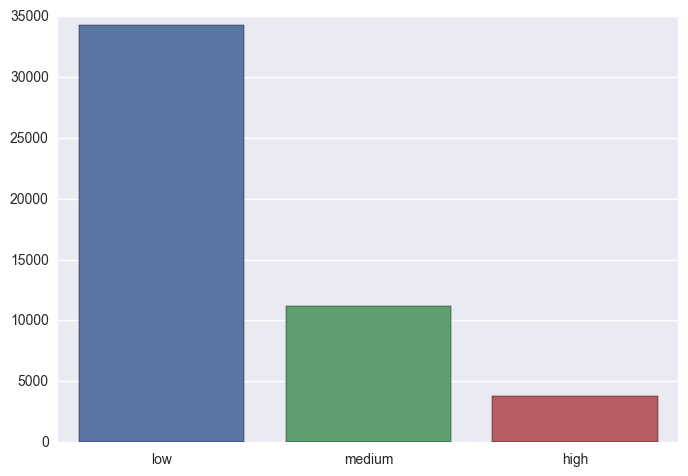

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

interest_level = train_df['interest_level'].value_counts()
x = interest_level.index
y = interest_level.values
sns.barplot(x, y )

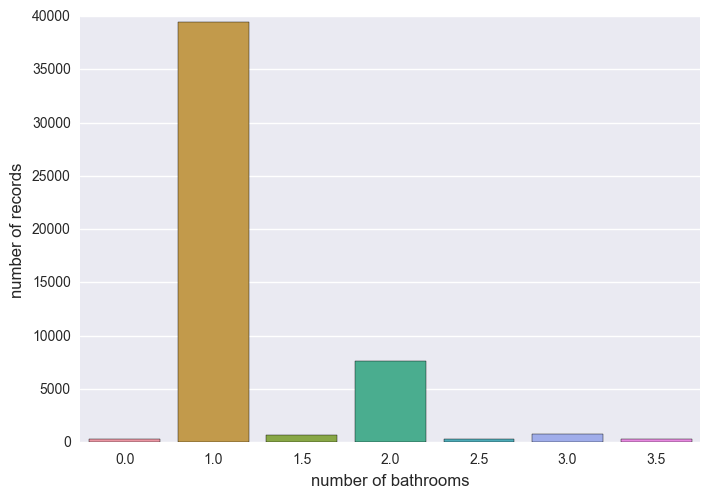

In [87]:
bathrooms = train_df['bathrooms'].value_counts()
x = bathrooms.index
y = bathrooms.values
sns.barplot(x, y )
plt.xlabel('number of bathrooms', fontsize=12)
plt.ylabel('number of records', fontsize=12)

In [5]:
train_df['bathrooms'].ix[train_df['bathrooms']>=3.5] = 3.5

/Users/zy/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


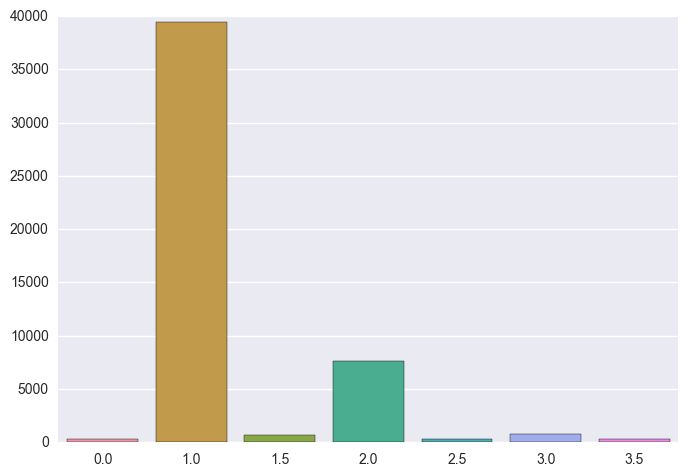

In [6]:
bathrooms = train_df['bathrooms'].value_counts()
x = bathrooms.index
y = bathrooms.values
sns.barplot(x, y )

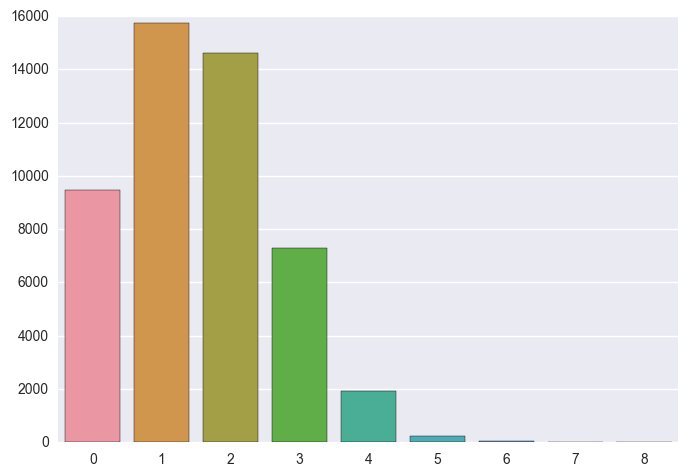

In [7]:
bedrooms = train_df['bedrooms'].value_counts()
x = bedrooms.index
y = bedrooms.values
sns.barplot(x, y )

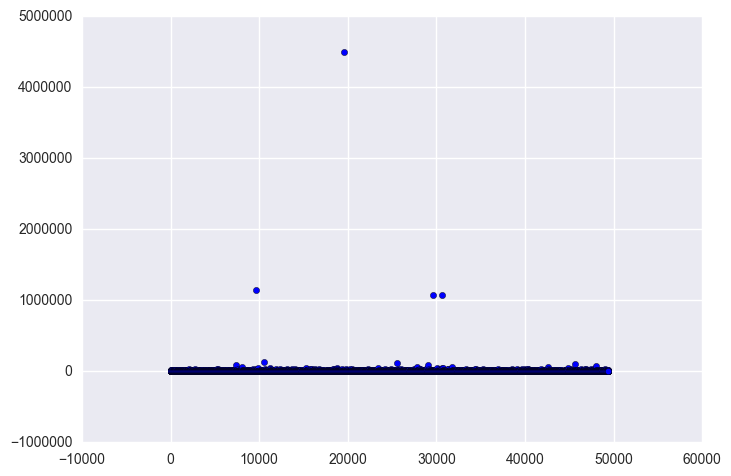

In [8]:
plt.scatter(range(len(train_df)), train_df.price)

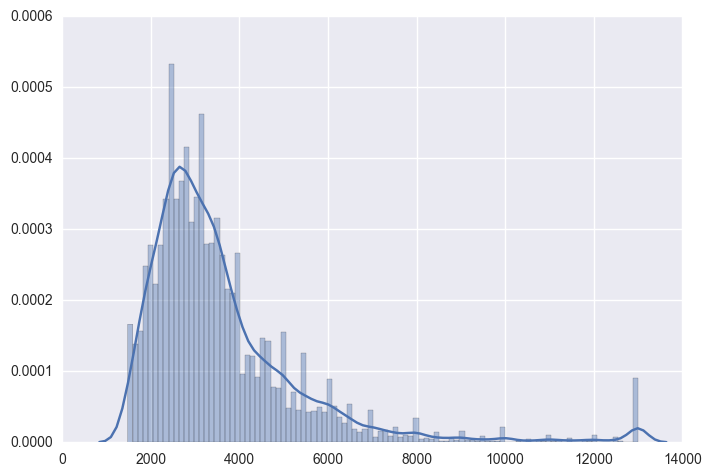

In [9]:
from scipy.stats.mstats import winsorize
train_df['price'] = winsorize(train_df['price'], limits=[0.01, 0.01])
sns.distplot(train_df.price.values, bins=100, kde=True)

In [10]:
import math
import numpy as np
train_df['Log_price']=np.log(train_df['price'].astype(float))

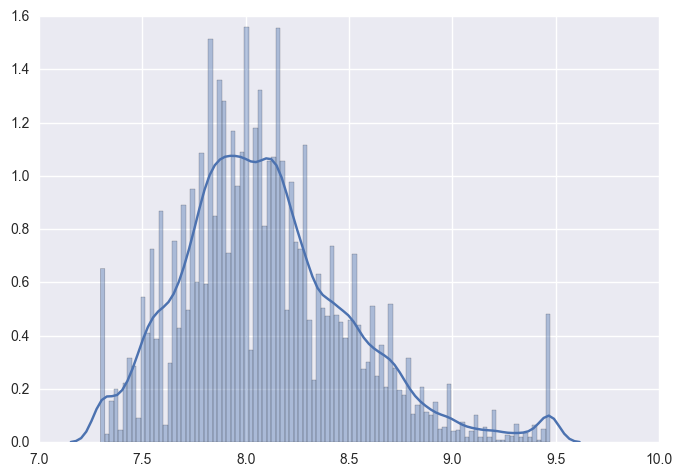

In [11]:
sns.distplot(train_df.Log_price.values, bins=100, kde=True)

In [12]:
#check for missing values
pd.isnull(train_df).sum()
pd.isnull(test_df).sum() 

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

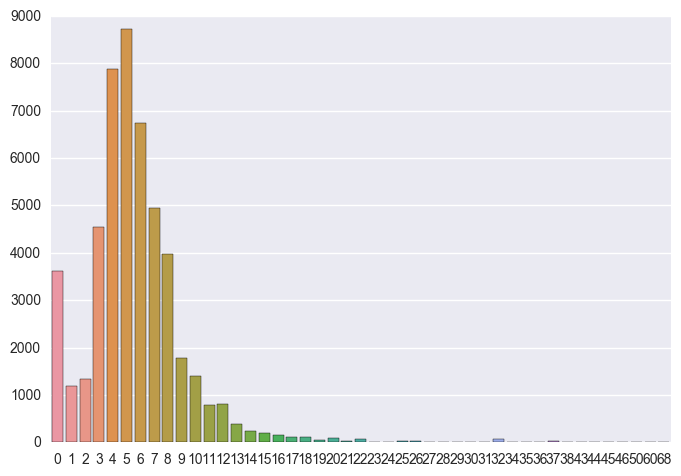

In [13]:
train_df['num_photos']=train_df['photos'].apply(len)
num_photos = train_df['num_photos'].value_counts()
x = num_photos.index
y = num_photos.values
sns.barplot(x, y )

/Users/zy/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


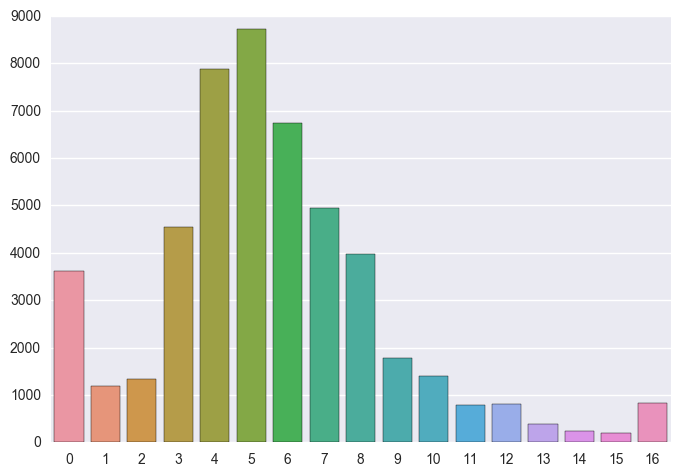

In [14]:
train_df['num_photos'].ix[train_df['num_photos']>=16] = 16
num_photos = train_df['num_photos'].value_counts()
x = num_photos.index
y = num_photos.values
sns.barplot(x, y )

In [15]:
train_df["created_year"] = pd.to_datetime(train_df["created"], coerce=True).dt.year
train_df["created_month"] = pd.to_datetime(train_df["created"], coerce=True).dt.month
train_df["created_day"] = pd.to_datetime(train_df["created"], coerce=True).dt.day

/Users/zy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
  if __name__ == '__main__':
/Users/zy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
  from ipykernel import kernelapp as app
/Users/zy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
  app.launch_new_instance()


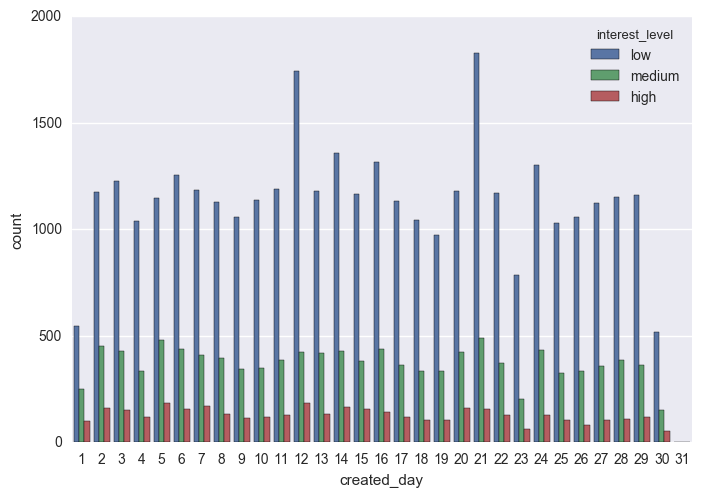

In [147]:
sns.countplot(x="created_day", hue="interest_level", hue_order=['low', 'medium', 'high'], data=train_df)

In [71]:
train_df["description_score"] = train_df['description'].apply(process)

### Data Cleaning

In [3]:
wd = "/Users/zy/Documents/2017Spring/DataMinning/Project/data"
train_df = pd.read_json(wd+"/train.json")
train_df = train_df.reset_index(drop=True)
test_df = pd.read_json(wd+"/test.json")
test_df = test_df.reset_index(drop=True)

#### * Train Data

In [4]:
#train_df["description_score"] = train_df['description'].apply(process)
#train_score = train_df["description_score"].to_frame()
#train_score.to_csv("data/train_score.csv")
df = pd.read_csv("https://raw.githubusercontent.com/YingZhang1028/practicum/master/Data_DataMining/train_score.csv")
train_df["description_score"] = df["description_score"]
train_df["description_score"].ix[np.isnan(train_df["description_score"]) == True] = train_df["description_score"].mean()

/Users/zy/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
train_df["num_description"]= train_df["description"].apply(num_description)
#train_df["num_description"]= train_df["description"].apply(lambda x: len(word.findall(x)))

In [6]:
train_df['bathrooms'].ix[train_df['bathrooms']>=3.5] = 3.5
train_df['price'] = winsorize(train_df['price'], limits=[0.01, 0.01])
train_df['Log_price']=np.log(train_df['price'].astype(float))
train_df['num_photos']=train_df['photos'].apply(len)

train_df["created_month"] = pd.to_datetime(train_df["created"], coerce=True).dt.month
train_df["created_day"] = pd.to_datetime(train_df["created"], coerce=True).dt.day
train_df["created_dayofyear"]=pd.to_datetime(train_df["created"], coerce=True).dt.dayofyear
train_df["num_features"] = train_df["features"].apply(len)

/Users/zy/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/zy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
/Users/zy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
/Users/zy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


In [7]:
train_df["display_address"] = encoding(train_df,"display_address")
train_df["street_address"] = encoding(train_df,"street_address")
train_df["manager_id"] = encoding(train_df,"manager_id")
train_df["building_id"] = encoding(train_df,"building_id")

#### * Test Data

In [8]:
#test_df["description_score"] = test_df['description'].apply(process)
#test_score = test_df["description_score"].to_frame()
#test_score.to_csv("data/test_score.csv")
df = pd.read_csv("https://raw.githubusercontent.com/YingZhang1028/practicum/master/Data_DataMining/test_score.csv")
test_df["description_score"] = df["description_score"]
test_df["description_score"].ix[np.isnan(test_df["description_score"]) == True] = test_df["description_score"].mean()

/Users/zy/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
test_df["num_description"]= test_df["description"].apply(num_description)
#word = re.compile('\w{3,}')
#test_df["num_description"]= test_df["description"].apply(lambda x: len(word.findall(x)))

In [10]:
test_df['bathrooms'].ix[test_df['bathrooms']>=3.5] = 3.5
test_df['price'] = winsorize(test_df['price'], limits=[0.01, 0.01])
test_df['Log_price']=np.log(test_df['price'].astype(float))
test_df['num_photos']=test_df['photos'].apply(len)

test_df["created_dayofyear"]=pd.to_datetime(test_df["created"], coerce=True).dt.dayofyear
test_df["created_month"] = pd.to_datetime(test_df["created"], coerce=True).dt.month
test_df["created_day"] = pd.to_datetime(test_df["created"], coerce=True).dt.day
test_df["num_features"] = test_df["features"].apply(len)

/Users/zy/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/zy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
/Users/zy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
/Users/zy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


In [11]:
test_df["display_address"] = encoding(test_df,"display_address")
test_df["street_address"] = encoding(test_df,"street_address")
test_df["manager_id"] = encoding(test_df,"manager_id")
test_df["building_id"] = encoding(test_df,"building_id")

### 

In [12]:
train_df["manager_level_low"] = np.nan
train_df["manager_level_medium"] = np.nan
train_df["manager_level_high"] = np.nan

for i in train_df["manager_id"].unique():
    df = train_df[train_df["manager_id"]== i]
    num = len(df)
    low = len(df[df["interest_level"]== "low"])
    high = len(df[df["interest_level"]== "high"])
    medium = len(df[df["interest_level"]== "medium"])
    pro_low = low/num
    pro_high = high/num
    pro_medium = medium/num 
    train_df['manager_level_low'].ix[train_df["manager_id"]== i] = pro_low
    train_df['manager_level_high'].ix[train_df["manager_id"]== i] = pro_high
    train_df['manager_level_medium'].ix[train_df["manager_id"]== i] = pro_medium
    
test_df["manager_level_low"] = np.nan
test_df["manager_level_medium"] = np.nan
test_df["manager_level_high"] = np.nan

for i in test_df["manager_id"].unique():
    if i in train_df["manager_id"].unique():
        pro_low = float(train_df[train_df["manager_id"]== i].manager_level_low.unique())
        pro_high = float(train_df[train_df["manager_id"]== i].manager_level_high.unique())
        pro_medium = float(train_df[train_df["manager_id"]== i].manager_level_medium.unique())
        test_df['manager_level_low'].ix[test_df["manager_id"]== i] = pro_low
        test_df['manager_level_high'].ix[test_df["manager_id"]== i] = pro_high
        test_df['manager_level_medium'].ix[test_df["manager_id"]== i] = pro_medium      

/Users/zy/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
def feature_extra(text):
    t = [i.replace(" ","").lower() for i in text]
    feature = ""
    for i in t:
        feature += i+" "
    return feature

train_df['feature_extraction'] = train_df["features"].apply(feature_extra)
test_df['feature_extraction'] = test_df["features"].apply(feature_extra)

tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df['feature_extraction'])
te_sparse = tfidf.transform(test_df['feature_extraction'])

In [13]:
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,Log_price,num_photos,created_month,created_day,created_dayofyear,num_features,manager_level_low,manager_level_medium,manager_level_high,feature_extraction
0,1.5,3,3797,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,12282,[],medium,40.7145,7211212,...,8.006368,5,6,24,176,0,0.744444,0.255556,0.000000,
1,1.0,2,8986,2016-06-12 12:19:27,,9080,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,8.606119,11,6,12,164,5,0.988372,0.011628,0.000000,doorman elevator fitnesscenter catsallowed dog...
2,1.0,1,8889,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",13719,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,7.955074,8,4,17,108,4,0.574627,0.365672,0.059701,laundryinbuilding dishwasher hardwoodfloors pe...
3,1.0,1,1848,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,10866,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,8.094073,3,4,18,109,2,0.806283,0.125654,0.068063,hardwoodfloors nofee
4,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,15072,[Pre-War],low,40.8241,6934781,...,8.116716,3,4,28,119,1,1.000000,0.000000,0.000000,pre-war


In [14]:
test_df.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,Log_price,num_photos,created_dayofyear,created_month,created_day,num_features,manager_level_low,manager_level_medium,manager_level_high,feature_extraction
0,1.0,1,10542,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,18330,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,...,7.989560,8,163,6,11,6,NaN,NaN,NaN,elevator laundryinbuilding laundryinunit dishw...
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,18413,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,...,7.955074,3,176,6,24,3,NaN,NaN,NaN,pre-war dogsallowed catsallowed


### XGboost : the best model

In [25]:
train_df["price_t"] =train_df["price"]/train_df["bedrooms"]
test_df["price_t"] = test_df["price"]/test_df["bedrooms"] 

train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 

train_df['price_per_room'] = train_df['price']/train_df['room_sum']
test_df['price_per_room'] = test_df['price']/test_df['room_sum']


train_df['half_bathrooms'] = train_df["bathrooms"] - train_df["bathrooms"].apply(int)
test_df['half_bathrooms'] = test_df["bathrooms"] - test_df["bathrooms"].apply(int)

In [18]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model


In [27]:
features_to_use = ["Log_price","num_photos","created_month","created_day","bathrooms", "bedrooms",
                 "latitude","longitude","description_score","num_features","num_description",
                  "manager_id", "building_id", "created_dayofyear",
                  "manager_level_low","manager_level_medium","manager_level_high", "display_address","street_address",
                  "price_t", "room_sum",'price_per_room','half_bathrooms'
                  ]

In [28]:
from scipy import sparse
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

(49352, 223) (74659, 223)


In [29]:
import xgboost as xgb
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[0]	train-mlogloss:1.0256	test-mlogloss:1.02729
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:0.964369	test-mlogloss:0.96737
[2]	train-mlogloss:0.911802	test-mlogloss:0.916025
[3]	train-mlogloss:0.866025	test-mlogloss:0.871745
[4]	train-mlogloss:0.827189	test-mlogloss:0.834218
[5]	train-mlogloss:0.794033	test-mlogloss:0.802169
[6]	train-mlogloss:0.764908	test-mlogloss:0.773733
[7]	train-mlogloss:0.740653	test-mlogloss:0.750645
[8]	train-mlogloss:0.716012	test-mlogloss:0.726976
[9]	train-mlogloss:0.694129	test-mlogloss:0.706213
[10]	train-mlogloss:0.674815	test-mlogloss:0.687971
[11]	train-mlogloss:0.657922	test-mlogloss:0.672176
[12]	train-mlogloss:0.643188	test-mlogloss:0.658479
[13]	train-mlogloss:0.629922	test-mlogloss:0.646121
[14]	train-mlogloss:0.6177	test-mlogloss:0.635061
[15]	train-mlogloss:0.607381	test-mlogloss:0.625675
[16]	train-mlogloss:0.597126	test

In [30]:
preds, model = runXGB(train_X, train_y, test_X, num_rounds=400)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("data/prediction.csv", index=False)

### The outcome

In [31]:
out_df[["listing_id","high","medium","low"]].head(10)

,listing_id,high,medium,low
0,7142618,0.072204,0.380277,0.547519
1,7210040,0.113386,0.273819,0.612795
2,7103890,0.124432,0.132424,0.743144
3,7143442,0.000051,0.000775,0.999174
4,6860601,0.080586,0.103095,0.816319
5,6840081,0.019829,0.070577,0.909595
6,6922337,0.000097,0.221687,0.778216
7,6913616,0.000116,0.001046,0.998838
8,6937820,0.105496,0.328262,0.566242
9,6893933,0.980709,0.008482,0.010809


### Neural Network

In [24]:
feature = ["Log_price","num_photos","created_month","created_day","bathrooms", "bedrooms",
                 "latitude","longitude","description_score","num_features","num_description",
                  "created_dayofyear",
                  "manager_level_low","manager_level_medium","manager_level_high", "display_address","street_address"]

from scipy import sparse
train_X_2 = sparse.hstack([train_df[feature], tr_sparse]).tocsr()
test_X_2 = sparse.hstack([test_df[feature], te_sparse]).tocsr()

target = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target[x]))

In [25]:
# Classifier
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import GridSearchCV
import time as time

clf_nn = MLPClassifier(solver='adam', shuffle=True,random_state=2016)
params = {
    'alpha': [1e-5], # 1e-5, 1e-4...
    'activation': ['tanh'], # 'relu', 'sigmoid'....
    'hidden_layer_sizes': [(30, 10, 5)]#, (30, 30, 5), (20, 20, 20), (30, 30, 5)]
}
gs_nn = GridSearchCV(clf_nn, param_grid=params, scoring='log_loss', n_jobs=2, cv=10, verbose=2, refit=True) # cv=5
start = time.time()
gs_nn.fit(train_X_2,train_y)
print('- Time: %.2f minutes' % ((time.time() - start)/60))
print('- Best score: %.4f' % gs_nn.best_score_)
print('- Best params: %s' % gs_nn.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[CV] alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) ....
[CV] alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) ....


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) -   4.3s
[CV] alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) ....


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) -   4.8s
[CV] alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) ....


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) -   3.4s
[CV] alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) ....


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) -   4.7s
[CV] alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) ....


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) -   3.3s
[CV] alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) ....


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) -   5.8s
[CV] alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) ....


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) -   4.3s
[CV] alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) ....


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) -   3.7s
[CV] alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) ....


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) -   3.1s


/Users/zy/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  alpha=1e-05, activation=tanh, hidden_layer_sizes=(30, 10, 5) -   4.4s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   22.4s finished


- Time: 0.42 minutes
- Best score: -0.7877
- Best params: {'alpha': 1e-05, 'activation': 'tanh', 'hidden_layer_sizes': (30, 10, 5)}


### Random Forest

In [83]:
#Impute Missing Values
from sklearn.preprocessing import Imputer
fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
train_imputed = pd.DataFrame(fill_NaN.fit_transform(train_df[feature_to_use]))
train_imputed.columns = train_df[feature_to_use].columns
train_imputed.index = train_df.index

test_imputed = pd.DataFrame(fill_NaN.fit_transform(test_df[feature_to_use]))
test_imputed.columns = test_df[feature_to_use].columns
test_imputed.index = test_df.index

In [28]:
#Build final dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

train_X = sparse.hstack([train_imputed, tr_sparse]).tocsr()
test_X = sparse.hstack([test_imputed, te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape, train_y.shape)

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.20)

print("Training...n_estimators=100")
clf = ExtraTreesClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_val_pred = clf.predict_proba(X_val)
print(log_loss(y_val, y_val_pred))


(49352, 219) (74659, 219) (49352,)
Training...n_estimators=100
0.736326344359


In [16]:
train_df.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,Log_price,num_photos,created_month,created_day,created_dayofyear,num_features,manager_level_low,manager_level_medium,manager_level_high,feature_extraction
0,1.5,3,3797,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,12282,[],medium,40.7145,7211212,...,8.006368,5,6,24,176,0,0.744444,0.255556,0.0,


### Surrogate Model

In [93]:
predict, model = runXGB(train_X, train_y, train_X, num_rounds=400)
out_train = pd.DataFrame(predict)

In [94]:
out_train.columns = ["high", "medium", "low"]
out_train.head()

,high,medium,low
0,0.000273,0.401475,0.598252
1,0.000010,0.003006,0.996984
2,0.164398,0.540704,0.294898
3,0.006340,0.034250,0.959410
4,0.000019,0.000118,0.999863


In [95]:
from sklearn.tree import export_graphviz
lt = ["low","medium","high"]
predict = out_train[lt].idxmax(axis=1)
target = {'high':0, 'medium':1, 'low':2}
predict= np.array(predict.apply(lambda x: target[x]))

In [96]:
features = ["Log_price","num_photos","created_month","created_day","bathrooms", "bedrooms",
            "latitude","longitude","description_score","num_features","num_description",
            "created_dayofyear","manager_level_low","manager_level_medium","manager_level_high", "display_address","street_address"]
X = train_df[features].iloc[:,0:].values

In [102]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, min_samples_split=2, max_features=4)
clf = clf.fit(X, predict)
tree.export_graphviz(clf, out_file='dt.dot',feature_names=features)

In [110]:
import pydotplus 
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file=None,feature_names= features,class_names = ["high","medium","low"]) 
graph = pydotplus.graph_from_dot_data(dot_data)   
#graph.write_pdf("dt2.pdf")

True

In [81]:
out_train = out_df
train = train_df
train["interest_level"] = out_train[["high","medium","low"]].idxmax(axis=1).apply(lambda x: target[x])
train[["high","medium","low"]] = out_train[["high","medium","low"]]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,manager_level_low,manager_level_medium,manager_level_high,feature_extraction,building_level_low,building_level_medium,building_level_high,high,medium,low
0,1.5,3,3797,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,12282,[],2,40.7145,7211212,...,0.744444,0.255556,0.000000,,0.666667,0.333333,0.000000,0.213387,0.258345,0.528268
1,1.0,2,8986,2016-06-12 12:19:27,,9080,"[Doorman, Elevator, Fitness Center, Cats Allow...",2,40.7947,7150865,...,0.988372,0.011628,0.000000,doorman elevator fitnesscenter catsallowed dog...,0.916667,0.083333,0.000000,0.173499,0.123002,0.703498
2,1.0,1,8889,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",13719,"[Laundry In Building, Dishwasher, Hardwood Flo...",2,40.7388,6887163,...,0.574627,0.365672,0.059701,laundryinbuilding dishwasher hardwoodfloors pe...,0.379310,0.448276,0.172414,0.046577,0.085019,0.868404
3,1.0,1,1848,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,10866,"[Hardwood Floors, No Fee]",2,40.7539,6888711,...,0.806283,0.125654,0.068063,hardwoodfloors nofee,0.898990,0.090909,0.010101,0.000029,0.000379,0.999592
4,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,15072,[Pre-War],2,40.8241,6934781,...,1.000000,0.000000,0.000000,pre-war,0.915762,0.060705,0.023534,0.096201,0.097723,0.806076


In [83]:
#train.to_csv("data/Surrogate.csv",index=False)